## Introduction
This is a notebook designed to illustrate some of the basics of colloid filtration theory and how we can incorporate these mechanistic calculations into our reactive transport equations.

First we import the libraries that we need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc as erfc

## Colloid Filtration Theory
Let's define a function to calculate the diffusion, interception, and sedimentation collector contact efficiency. These are equations 6-8 in [Yao et al, 1971](https://pubs.acs.org/doi/10.1021/es60058a005).

In [2]:
def eta_calc(dp, d, v, rho_p):
    # Constants
    # gravity
    g = 9.81 # m*s^-2
    # boltzman constant
    k = 1.38064852E-23 # units: m^2*kg*s^-2*K^-1
    
    # Water properties
    # absolute temperature
    T = 298.15 # Kelvin
    # water viscosity
    mu = 8.90E-4 # Pa·s
    # water density
    rho_w = 997 # kg*m^3
    
    # collector efficiency 
    # diffusion single collector efficiency (Equation 6 from Yao 1971)
    eta_d = 0.9*(k*T/(mu*dp*d*v))**(2/3) # a good check of this equation is to calculate the units
    # interception single collector efficiency (Equation 7 from Yao 1971)
    eta_i = (3/2)*(dp/d)**2
    # sedimentation single collector efficiency (Equation 8 from Yao 1971)
    eta_g = (rho_p - rho_w)*g*dp**2/ (18*mu*v)
    
    return eta_d, eta_i, eta_g

Now lets see if we can recreate Figure 3 from [Yao et al, 1971](https://pubs.acs.org/doi/10.1021/es60058a005).

In [3]:
# particle diameter defined as the dependent variable.
# Note the function np.logspace is very similiar to np.linspace except that it now returns an array
# of values evenly distributed in logarithmic space
dp = np.logspace(-2, 3, num=100)* 1e-6 # meters
# collector (i.e. sand grain) diameter
d = 500 * 1e-6 # meters
# advection velocity 
v = 2*0.679/1000 # meters per second 
# particle density
rho_p = 1050

eta_d, eta_i, eta_g = eta_calc(dp, d, v, rho_p)

# remember that these different components of the contact efficiency are additive
eta = eta_d + eta_i + eta_g

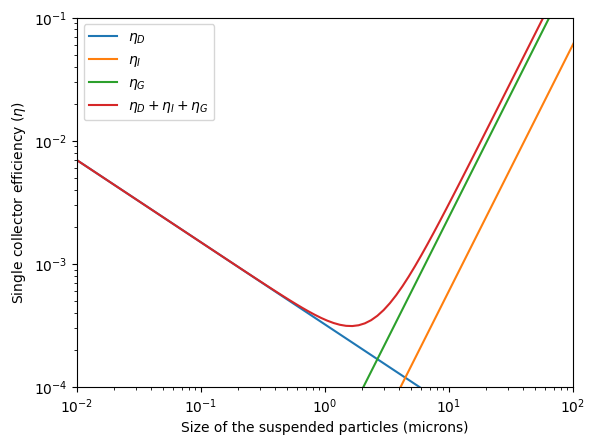

In [5]:
# now let's plot the results. We are dividing the particle size by 1e-6 so that our plot is in units of microns on the x-axis
plt.plot(dp/ 1e-6, eta_d, label = '$\eta_D$')
plt.plot(dp/ 1e-6, eta_i, label = '$\eta_I$')
plt.plot(dp/ 1e-6, eta_g, label = '$\eta_G$')
plt.plot(dp/ 1e-6, eta, label = '$\eta_D + \eta_I + \eta_G$')
# set axis to loglog 
plt.yscale('log')
plt.xscale('log')
# set axis limits to match paper
plt.ylim([1E-4, 1E-1])
plt.xlim([1E-2, 1E2])

# label plot
plt.ylabel('Single collector efficiency ($\eta$)')
plt.xlabel('Size of the suspended particles (microns)')
plt.legend()
plt.show()

Spend some time thinking about how these lines change with changes in advection velocity, particle density, particle size, etc. Discuss within your group what types of forces or properties this model is neglecting.

### Deposition rate coefficients

This mechanistic description of colloid filtration on a single sand grain (also termed collector) can be extended to a porous media through the definition of a deposition rate coefficient (usually expressed in notes/literature as $k_d$, $k_f$, or $k_c$). This deposition rate coefficient can then be incorporated into previous analytical solutions that we explored in the reactive contaminants module (the ```mu``` variable in the analytical solutions).

In [6]:
# Equation 5 in Li et al 2004 (10.1021/es049154v) or Equation 20 in Tufenkji and Elimelech, 2004 (10.1021/es034049r)
# alpha is the attachment efficiency
# phi is the porosity 
def kc_calc(d, v, alpha, phi, eta):
    kc = 3/2*(1-phi)*v*alpha*eta/d
    return kc

In [7]:
# alpha is the attachment efficiency
alpha = 1 # for now assume fully favorable conditions (every particle that hits a grain of sand sticks)
# phi is the porosity 
phi = 0.3 # porosity of a typical sand pack
# let's define a single colloid size
dp = 10* 1e-6 # meters
# and recalculate eta for this single value of dp
eta_d, eta_i, eta_g = eta_calc(dp, d, v, rho_p)
eta = eta_d + eta_i + eta_g

kc = kc_calc(d, v, alpha, phi, eta)
print('Deposition rate coefficient = ' + str(kc))

Deposition rate coefficient = 0.008725342933927141


##### What are the units of this deposition rate coefficient? Does this agree with the units that we had for first order reaction terms?

### Analytical solution: Type 1 boundary conditions with first order reaction

Remember back to our [First Order Reactions notebook](https://github.com/zahasky/Contaminant-Hydrogeology-Activities/blob/master/First%20Order%20Reactions.ipynb) were we described the analytical solution to the ADE with following function. Note that here we are not interested in zero order production or retardation so the function has been simplified to remove ```gamma```.

In [8]:
# Retardation with 1st type BC (equation C5 of Analytical Solutions of the 1D Convective-Dispersive Solute Transport Equation)
def ADEwReactions_type1_fun(x, t, v, D, mu, C0, t0, Ci):
    # We are not focused on sorption so R can be set to one (equivalent to kd = 0)
    R = 1
    # 'u' term identical in equation c5 and c6 (type 3 inlet)
    u = v*(1+(4*mu*D/v**2))**(1/2)
    
    # Note that the '\' means continued on the next line
    Atrf = np.exp(-mu*t/R)*(1- (1/2)* \
        erfc((R*x - v*t)/(2*(D*R*t)**(1/2))) - \
        (1/2)*np.exp(v*x/D)*erfc((R*x + v*t)/(2*(D*R*t)**(1/2))))
    
    # term with B(x, t)
    Btrf = 1/2*np.exp((v-u)*x/(2*D))* \
        erfc((R*x - u*t)/(2*(D*R*t)**(1/2))) \
        + 1/2*np.exp((v+u)*x/(2*D))* erfc((R*x + u*t)/ \
        (2*(D*R*t)**(1/2)))
    
    # if a pulse type injection
    if t0 > 0:
        tt0 = t - t0
        
        indices_below_zero = tt0 <= 0
        # set values equal to 1 (but this could be anything)
        tt0[indices_below_zero] = 1
    
        Bttrf = 1/2*np.exp((v-u)*x/(2*D))* \
            erfc((R*x - u*tt0)/(2*(D*R*tt0)**(1/2))) \
            + 1/2*np.exp((v+u)*x/(2*D))* erfc((R*x + u*tt0)/ \
            (2*(D*R*tt0)**(1/2)))
        
        # Now set concentration at those negative times equal to 0
        Bttrf[indices_below_zero] = 0
        
        C_out = Ci*Atrf + C0*Btrf - C0*Bttrf
        
    else: # if a continous injection then ignore the Bttrf term (no superposition)
        C_out = Ci*Atrf + C0*Btrf
        
    
    # Return the concentration (C) from this function
    return C_out

In [9]:
# define observation location
x = 0.1 # meters
# define time 
t = np.linspace(0.1, 45*60, num=1000) # seconds
# lets also slow down the advection velocity a little
v = 0.0002 # m/s
# dispersion
D = 0.03*v # cm^2/s

# conservative solute (notice that we set mu=0)
C_solute = ADEwReactions_type1_fun(x, t, v, D, 0, 1, 0, 0)
# particles solute (notice that we set mu=kf)
C_particles = ADEwReactions_type1_fun(x, t, v, D, kc, 1, 0, 0)

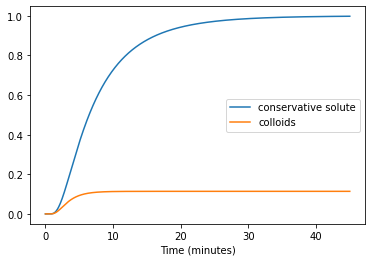

In [24]:
plt.plot(t/60, C_solute, label = 'conservative solute')
plt.plot(t/60, C_particles, label = 'colloids')
# add legend
plt.legend()
plt.xlabel('Time (minutes)')
plt.show()

## Activity: Calculated deposition rate coefficient from the breakthrough curves
Now image that you measured the ```C_solute``` and ```C_particles``` (that are plotted in the previous cell) in lab. Based on this data, calculate the desposition rate coefficient. The equation to do this is in the slides and given by: 

$C/C_0 = \text{exp}(-k_c L/v)$

You will need to rearrange this equation to solve for $k_c$.

In [10]:
# start by indexing the last value measured in C_particles. 
# C_div_C0 = ...

# print(C_div_C0)

In [25]:
# Uncomment this based on the rearranged equation you wrote out in the first cell.
kc_btc = -np.log(C_particles[-1]/1)*v/x

print('Deposition rate coefficient calculated from btc = ' + str(kc_btc))
print('Analytical model deposition rate coefficient input = ' + str(kc))

Deposition rate coefficient calculated from btc = 0.004343107275224052
Analytical model deposition rate coefficient input = 0.007172494395769957


How does the $k_c$ value input into the analytical solution compare with the value calculated from the breakthrough curves? 

## Bonus: Explore a more complicated temporal moment analysis when we are dealing with finite pulses or plumes of solutes experience first order reactions

A natural next question is how to calculate the deposition rate coefficient if we have a pulse of solute rather than continous injection/source. Let's start be using our same functions that we defined above but now with a finite pulse.

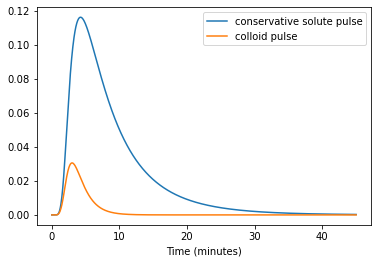

In [16]:
# dispersion
D = 0.03*v
pulse_time = 60 # seconds
# initial concentration
C0 = 1

# conservative solute (notice that we set mu=0)
C_solute_pulse = ADEwReactions_type1_fun(x, t, v, D, 0, C0, pulse_time, 0)
# particles solute (notice that we set mu=kf)
C_particles_pulse = ADEwReactions_type1_fun(x, t, v, D, kc, C0, pulse_time, 0)
plt.plot(t/60, C_solute_pulse, label = 'conservative solute pulse')
plt.plot(t/60, C_particles_pulse, label = 'colloid pulse')
plt.legend()
plt.xlabel('Time (minutes)')
plt.show()

To calculate the deposition rate coeffient we will use the method of the temporal moments as described in detail in [Pang et al, 2003](https://www.sciencedirect.com/science/article/pii/S016977220200061X) and references therein.

In [13]:
# remember from moment analysis that we have
# zero temporal moment
M0 = np.trapz(C_particles_pulse, t)

# Pang et al 2003 Equation 10
kc_btc_pulse = (v**2/(4*D))*((1- (2*D/(x*v))*np.log(M0/(C0*pulse_time)))**2 -1)

# Print the output and compare it with our model input!!
print('Deposition rate coefficient calculated from btc = ' + str(kc_btc_pulse))
print('Analytical model deposition rate coefficient input = ' + str(kc))

Deposition rate coefficient calculated from btc = 0.007478865371980954
Analytical model deposition rate coefficient input = 0.00747886537193755


How does it look?!